In [1]:
# File name: prepare_dataset.ipynb
# Authors: Anton Karazeev <anton.karazeev@gmail.com>, Anton Lukashchuk <academik116@gmail.com>
#
# This file is part of REDE project (https://github.com/akarazeev/REDE)
#
# Description: content of this file was used to build a dataset
# callsed REDE - Reverse Engineering in Dispersion Engineering.
# Files from utils/matlab_data/ were used as raw data. These data
# contain information about system's simulations with given set of
# parameters.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os
import tqdm
import pickle
import scipy.io as spio


def preproc(freqs, modes):
    c = 2.99792458e8
    T0 = 282e12
    N = 20000

    # Corrected here // AL 20.03
    m1 = round(min(modes))
    m2 = round(max(modes))
    m_int = np.arange(m1, m2+1)
    tck = interpolate.CubicSpline(modes, freqs)
    omega_int = tck(m_int)
    #####
    
    modes_total = np.linspace(min(modes), max(modes), N)
    omega_total = tck(modes_total)

    h = (max(modes) - min(modes)) / (N - 1)

    D1_total = np.diff(omega_total) / h
    D2_total = np.diff(D1_total) / h

    modes_total = modes_total[:-1]
    omega_total = omega_total[:-1]

    # Corrected here // AL 20.03
    ind_int = np.argmin(abs(T0 - omega_int))
    ind = np.argmin(abs(modes_total - m_int[ind_int]))
    #####

    w0 = omega_total[ind]
    m0 = modes_total[ind]
    D1 = D1_total[ind]
  
    omega_grid = w0 + (D1 * (modes_total - m0))

    delta = (omega_total - omega_grid) % D1
    delta_omega_total = delta - (np.sign(delta - (D1 / 2)) * D1 * (abs(delta) > (D1 / 2)))
    lambda_grid = c / omega_total
    
    # Get rid off data when Dint is more than 200GHz 
    a = ((omega_total<282e12) & (abs(delta_omega_total) > 200e9))
    
    if omega_total[a].shape[0] != 0:
        get_rid_ind = np.argmin(abs(max(omega_total[a]) - omega_total) )
        omega_total = omega_total[get_rid_ind+1:]
        delta_omega_total = delta_omega_total[get_rid_ind+1:]
    #####
            
    return omega_total, delta_omega_total, D1_total, D2_total

In [7]:
def df_by_filepath(filepath):
    # Load data.
    mat = spio.loadmat(filepath, squeeze_me=True)

    struct = mat['str']
    header = ['id']
    header.extend(struct[0][1].dtype.names)
    header

    # Create DataFrame.
    dataset = []

    for i in range(len(struct)):
        tmp = [int(struct[i][0])]
        tmp.extend([float(struct[i][1][name]) for name in header[1:]])
        dataset.append(tmp)

    df_data = pd.DataFrame(data=dataset, columns=header)
    return df_data, struct

In [8]:
df_data, struct = df_by_filepath('matlab_data/set_1848_elements.mat')
df_data.head()

,id,gap,width1,height,radius1,width2
0,1,2.500000e-07,0.000001,7.000000e-07,0.000018,8.000000e-07
1,2,2.500000e-07,0.000001,7.000000e-07,0.000018,8.400000e-07
2,3,2.500000e-07,0.000001,7.000000e-07,0.000018,8.800000e-07
3,4,2.500000e-07,0.000001,7.000000e-07,0.000018,9.200000e-07
4,5,2.500000e-07,0.000001,7.000000e-07,0.000018,9.600000e-07


In [12]:
# Generate dataset.
frequencies_modes_list = []
parameters_list = []
images = []

for filepath in ['matlab_data/set_1848_elements.mat']:
    df_data, struct = df_by_filepath(filepath)

    for i in tqdm.tqdm(range(len(struct))):
        # Parameters.
        sample_id = int(struct[i][0])
        parameters = df_data[df_data['id'] == sample_id].values[0][1:]
        parameters_list.append(parameters)

        # Frequencies and modes.
        freqs, modes = struct[i][2][:, 0].real, struct[i][2][:, 2].real
        frequencies_modes_list.append((freqs, modes))

        # Images.
        omega_total, delta_omega_total, D1_total, D2_total = preproc(freqs, modes)
        fig = plt.figure(figsize=(2, 1))
        fig.add_subplot(111)
        plt.xlim((130, 430))
        plt.ylim((-500, 500))
        plt.axis('off')
        img = plt.scatter(omega_total * 1e-12, delta_omega_total * 1e-9, s=0.01)
        fig.canvas.draw()

        # Images -> arrays -> black and white.
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        data = data[5:-5, 20:-13, 0]
        data = (data < 200) * 255
        data = data.astype('uint8')
        images.append(data)
        plt.close()

100%|██████████| 1848/1848 [03:14<00:00,  9.52it/s]


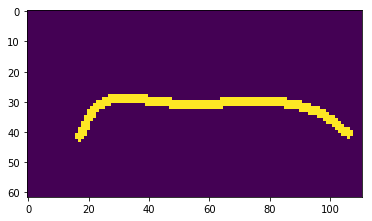

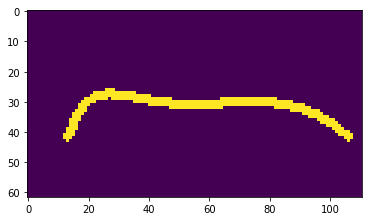

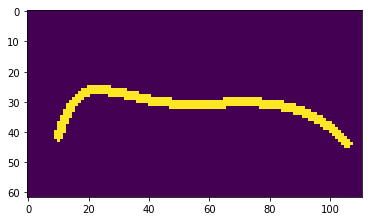

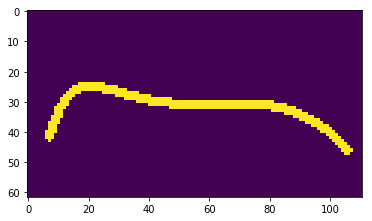

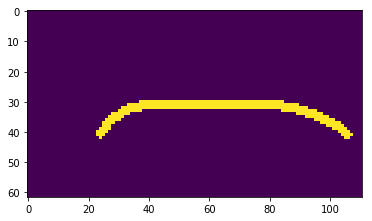

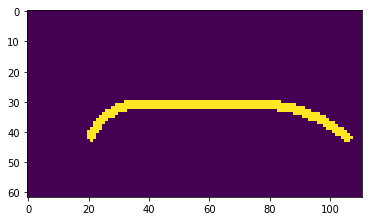

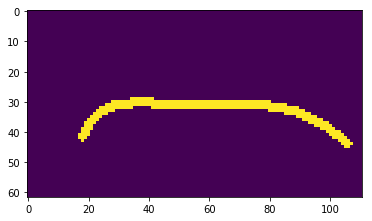

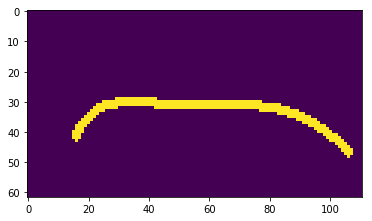

In [13]:
for i in range(172, 180):
    plt.imshow(images[i])
    plt.show()

In [14]:
# Convert to np.array.
images = np.array(images)
frequencies_modes_list = np.array(frequencies_modes_list)
parameters_list = np.array(parameters_list)

with open('dataset/{}-5-parameters.pkl'.format(len(images)), 'wb') as f:
    pickle.dump(parameters_list, f)

with open('dataset/{}-frequencies_modes.pkl'.format(len(images)), 'wb') as f:
    pickle.dump(frequencies_modes_list, f)

with open('dataset/{}-62-111-images.pkl'.format(len(images)), 'wb') as f:
    pickle.dump(images, f)